In [1]:
# Python Dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from pyspark.sql import functions as F


In [2]:
# Import findspark and initialize. 
import findspark
findspark.init()

In [3]:
# Import packages
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date,when
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [4]:
# Store filepath in a variable
constituents_path = Path("./Resources/constituents.csv")

In [5]:
# 1. Read CSV file 
constituents_df = spark.read.csv(str(constituents_path), sep=",", header=True)
# Show the dataframe


In [6]:
constituents_df.columns

['ConstituentID',
 'City',
 'State',
 'Postcode',
 'Country',
 'Constituent type',
 'Constituent codes',
 'Lifetime giving',
 'First gift amount',
 'First gift type',
 'First gift date',
 'First gift fund',
 'Latest gift amount',
 'Latest gift type',
 'Latest gift date',
 'Latest gift fund',
 'Greatest gift amount',
 'Greatest gift type',
 'Greatest gift date',
 'Greatest gift fund',
 'Birthdate',
 'Age',
 'AgeInMonths',
 'PrimaryEmployment',
 'Education',
 'Gender',
 'Marital status',
 'Solicit codes',
 'Student Organizations',
 'Arts',
 'Fraternal Organizations',
 "Men's Athletics",
 'Scholarship Recipient',
 "Women's Athletics"]

In [7]:
constituents_df.printSchema()

root
 |-- ConstituentID: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Constituent type: string (nullable = true)
 |-- Constituent codes: string (nullable = true)
 |-- Lifetime giving: string (nullable = true)
 |-- First gift amount: string (nullable = true)
 |-- First gift type: string (nullable = true)
 |-- First gift date: string (nullable = true)
 |-- First gift fund: string (nullable = true)
 |-- Latest gift amount: string (nullable = true)
 |-- Latest gift type: string (nullable = true)
 |-- Latest gift date: string (nullable = true)
 |-- Latest gift fund: string (nullable = true)
 |-- Greatest gift amount: string (nullable = true)
 |-- Greatest gift type: string (nullable = true)
 |-- Greatest gift date: string (nullable = true)
 |-- Greatest gift fund: string (nullable = true)
 |-- Birthdate: string (nullable = true)
 |-- Age: string (nullable 

In [10]:
#Find the null columns counts
# Create a list of columns to check for NULLs
columns = constituents_df.columns

# Create an expression for each column to count NULLs
null_counts = [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in columns]

# Use the select and agg functions to count NULLs for each column
null_counts_df = constituents_df.select(null_counts)

# Show the result
#null_counts_df.show(5)
null_counts_df_panda = null_counts_df.toPandas()
null_counts_df_panda.head()

,ConstituentID,City,State,Postcode,Country,Constituent type,Constituent codes,Lifetime giving,First gift amount,First gift type,...,Education,Gender,Marital status,Solicit codes,Student Organizations,Arts,Fraternal Organizations,Men's Athletics,Scholarship Recipient,Women's Athletics
0,0,9120,9123,9138,0,0,0,0,39140,39140,...,18360,1213,31023,44367,48785,50120,49088,48342,44434,49314


In [8]:
#Change amounts coulumns to decimals 
constituents_df = constituents_df.withColumn("Lifetime giving", col("Lifetime giving").cast("decimal"))
constituents_df = constituents_df.withColumn("First gift amount", col("First gift amount").cast("decimal"))
onstituents_df = constituents_df.withColumn("Latest gift amount", col("Latest gift amount").cast("decimal"))
constituents_df = constituents_df.withColumn("Greatest gift amount", col("Greatest gift amount").cast("decimal"))
# Change to date format
#constituents_df = constituents_df.withColumn("First gift date", to_date(col("First gift date"), "MM-dd-yyyy"))
#constituents_df = constituents_df.withColumn("Latest gift date", to_date(col("Latest gift date"), "MM-dd-yyyy"))
#constituents_df = constituents_df.withColumn("Greatest gift date", to_date(col("Greatest gift date"), "MM-dd-yyyy"))

In [9]:
#Add new column for repeated 
constituents_df = constituents_df.withColumn('repeatedConstituents', when(col('Lifetime giving') > col('First gift amount'), 'Yes').otherwise('No'))

In [10]:
#Create a temporary view of the DataFrame.
constituents_df.createOrReplaceTempView('constituents')

In [40]:
#Counts at a glance and see the potential donor counts 
result_df =spark.sql("""
    SELECT 
        COUNT(CASE WHEN `First gift amount` IS NOT NULL THEN ConstituentID END) AS activeConstituent,
        COUNT(CASE WHEN `First gift amount` IS NULL THEN ConstituentID END) AS potentialConstituent,
        COUNT(CASE WHEN `repeatedConstituents`='Yes' THEN ConstituentID END) AS repeatedConstituent
       
    FROM 
        constituents 
  
""")
# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
result_pandas_df = result_df.toPandas()

result_pandas_df.fillna(0, inplace=True)
result_pandas_df.head()

,activeConstituent,potentialConstituent,repeatedConstituent
0,11462,39451,4358


Text(0.5, 1.0, 'Constituent Distribution')

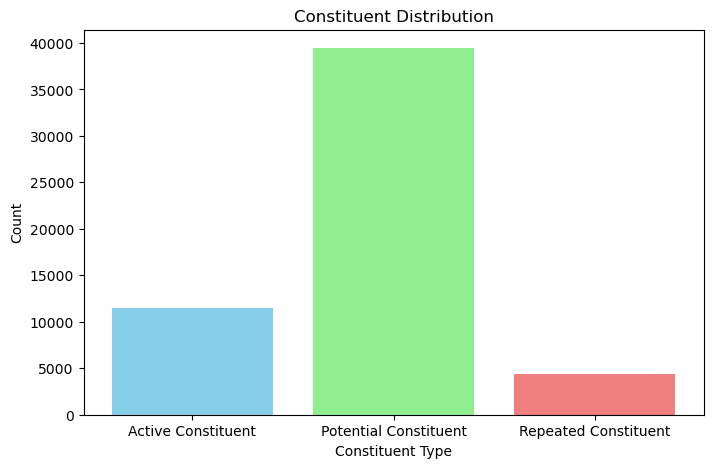

In [42]:
# Create a bar chart based on the data

# Extract the relevant data from your existing DataFrame
categories = ['Active Constituent', 'Potential Constituent', 'Repeated Constituent']
values = [
    result_pandas_df['activeConstituent'][0], 
    result_pandas_df['potentialConstituent'][0], 
    result_pandas_df['repeatedConstituent'][0]
     ]

# Plot the bar graph
plt.figure(figsize=(8, 5))  # Set figure size
plt.bar(categories, values, color=['skyblue', 'lightgreen', 'lightcoral'])

# Add labels and title
plt.xlabel('Constituent Type')
plt.ylabel('Count')
plt.title('Constituent Distribution')

# Show the plot

In [30]:
#Compare  the active and potential constituent against states and display top 5
#Plot the data in a barchart 

result_df =spark.sql("""
    SELECT 
        State,
         COUNT(CASE WHEN `First gift amount` IS NOT NULL THEN ConstituentID END) AS activeConstituent,
        COUNT(CASE WHEN `First gift amount` IS NULL THEN ConstituentID END) AS inactiveConstituent
       
    FROM 
        constituents 
    GROUP BY 
        State
    ORDER BY 
        activeConstituent desc
    LIMIT 5
""")
# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
result_pandas_df = result_df.toPandas()

result_pandas_df.fillna(0, inplace=True)
#result_pandas_df['POSTALCODE'] = result_pandas_df['POSTALCODE'].astype(str)
result_pandas_df.head()

,State,activeConstituent,inactiveConstituent
0,WI,4812,13761
1,MN,3772,10994
2,FL,306,578
3,CA,247,419
4,IL,213,485


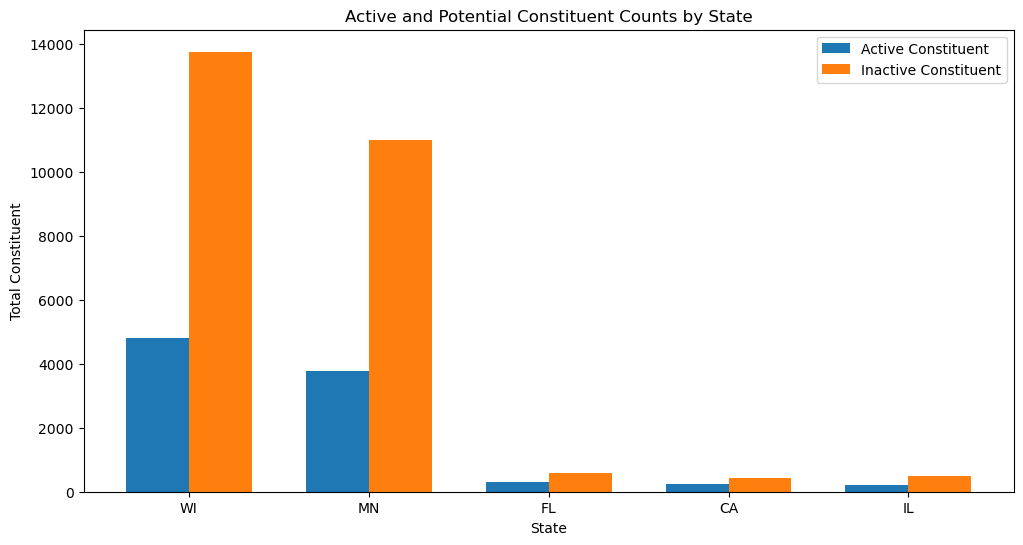

In [33]:
# Create a bar chart based on the data
# Set the figure size
plt.figure(figsize=(12, 6))

# Define the positions for each bar group
x = np.arange(len(result_pandas_df['State']))  # Label locations
width = 0.35  # Width of the bars

# Plot the bars for active and inactive constituents
plt.bar(x - width/2, result_pandas_df['activeConstituent'], width, label='Active Constituent')
plt.bar(x + width/2, result_pandas_df['inactiveConstituent'], width, label='Inactive Constituent')

# Add labels, title, and legend
plt.xlabel('State')
plt.ylabel('Total Constituent')
plt.title('Active and Potential Constituent Counts by State')
plt.xticks(x, result_pandas_df['State'])  # Set the x-ticks to the state names
plt.legend()

# Show the plot
plt.show()

In [28]:

# Execute the SQL query and store the result in a PySpark DataFrame
result_df = spark.sql("""
   SELECT 
      State, SUBSTRING(Postcode, 1, 5) AS POSTALCODE, count(`ConstituentID`) as totNotContribute
   FROM 
       constituents 
   WHERE 
      `First gift amount` IS NULL AND State IN ('WI')
   GROUP BY State, SUBSTRING(Postcode, 1, 5)
   ORDER BY State, totNotContribute DESC  
   LIMIT 10
""")
# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
result_pandas_df = result_df.toPandas()

result_pandas_df.fillna(0, inplace=True)
result_pandas_df['POSTALCODE'] = result_pandas_df['POSTALCODE'].astype(str)
result_pandas_df.head()

,State,POSTALCODE,totNotContribute
0,WI,54880,2806
1,WI,54843,357
2,WI,54806,353
3,WI,54874,271
4,WI,54873,227


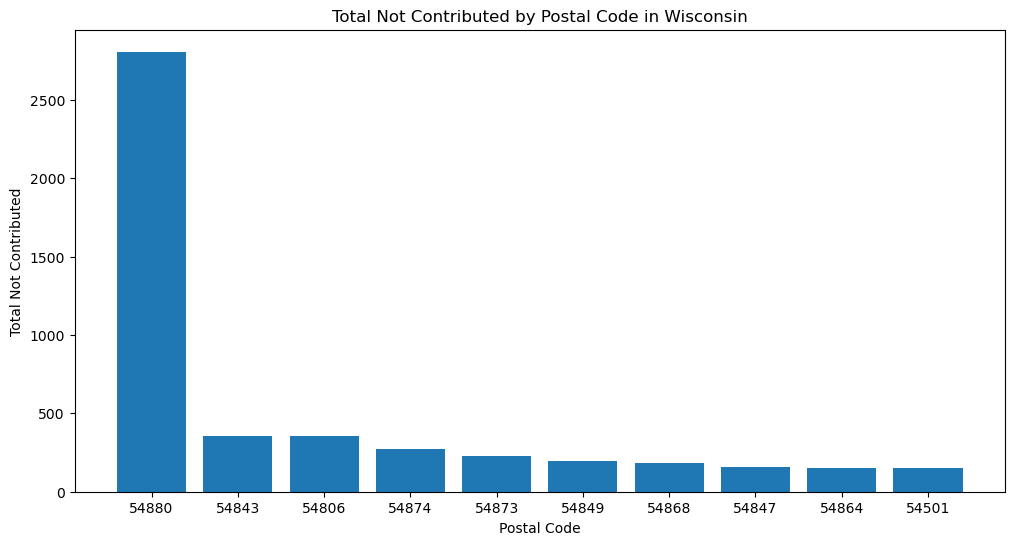

In [29]:
# Create a bar chart based on the data
plt.figure(figsize=(12, 6))
plt.bar(result_pandas_df['POSTALCODE'], result_pandas_df['totNotContribute'])
plt.xlabel('Postal Code')
plt.ylabel('Total Not Contributed')
plt.title('Total Not Contributed by Postal Code in Wisconsin')
plt.show()

In [56]:
#Country,State,Postcode,`Constituent type`,`Constituent codes`,Birthdate,Age,PrimaryEmployment,
#Education,Gender,`Marital status`,`Solicit codes`,`Student Organizations`,Arts,`Fraternal Organizations`,
# `Scholarship Recipient`

spark.sql("""
   SELECT 
      `Constituent type` ,count(`Constituent ID`) as totNotContribute
   FROM 
       constituents 
   WHERE 
      `First gift amount` IS NULL AND State IN ('WI','MN')
   GROUP BY `Constituent type`
   ORDER BY totNotContribute DESC  
""").show()

+----------------+----------------+
|Constituent type|totNotContribute|
+----------------+----------------+
|      Individual|           24415|
|    Organization|             340|
+----------------+----------------+



In [15]:
#Convert to Pandas dataframe
constituents_pd_df = constituents_df.toPandas()
constituents_pd_df.head()

,Constituent ID,City,State,Postcode,Country,Constituent type,Constituent codes,Lifetime giving,First gift amount,First gift type,...,Gender,Marital status,Solicit codes,Student Organizations,Arts,Fraternal Organizations,Men's Athletics,Scholarship Recipient,Women's Athletics,repeatedConstituents
0,60472,Superior,WI,54880-2556,United States,Organization,Business (No start date - No end date),0,0,None,...,None,None,None,None,None,None,None,None,None,No
1,43735,Hermantown,MN,55811-1755,United States,Organization,Other Organizations (8/29/2012 - No end date),50,50,One-time gift,...,None,None,None,None,None,None,None,None,None,No
2,60145,Esko,MN,55733-9645,United States,Organization,Other Organizations (No start date - No end date),50,50,One-time gift,...,None,None,None,None,None,None,None,None,None,No
3,21332,None,None,None,United States,Organization,Business (No start date - No end date),25,25,One-time gift,...,None,None,None,None,None,None,None,None,None,No
4,50410,Superior,WI,54880-1504,United States,Organization,Business (No start date - No end date),0,0,None,...,None,None,None,None,None,None,None,None,None,No
